In [8]:

pip install python_speech_features

  Created wheel for python-speech-features: filename=python_speech_features-0.6-py3-none-any.whl size=5887 sha256=59189748dac6ec4b144a273032dc8300131524dc79163fd14cbed4ac0e7deb2b
  Stored in directory: c:\users\hp\appdata\local\pip\cache\wheels\b0\0e\94\28cd6afa3cd5998a63eef99fe31777acd7d758f59cf24839eb
Successfully built python-speech-features
Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\users\hp\appdata\local\programs\python\python37\python.exe -m pip install --upgrade pip' command.


In [2]:
from python_speech_features import mfcc
import scipy.io.wavfile as wav

import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt

from tempfile import TemporaryFile
from sklearn.metrics import confusion_matrix
import os
import pickle
import random
import operator

import math

(1025, 1293)
(1025, 5)


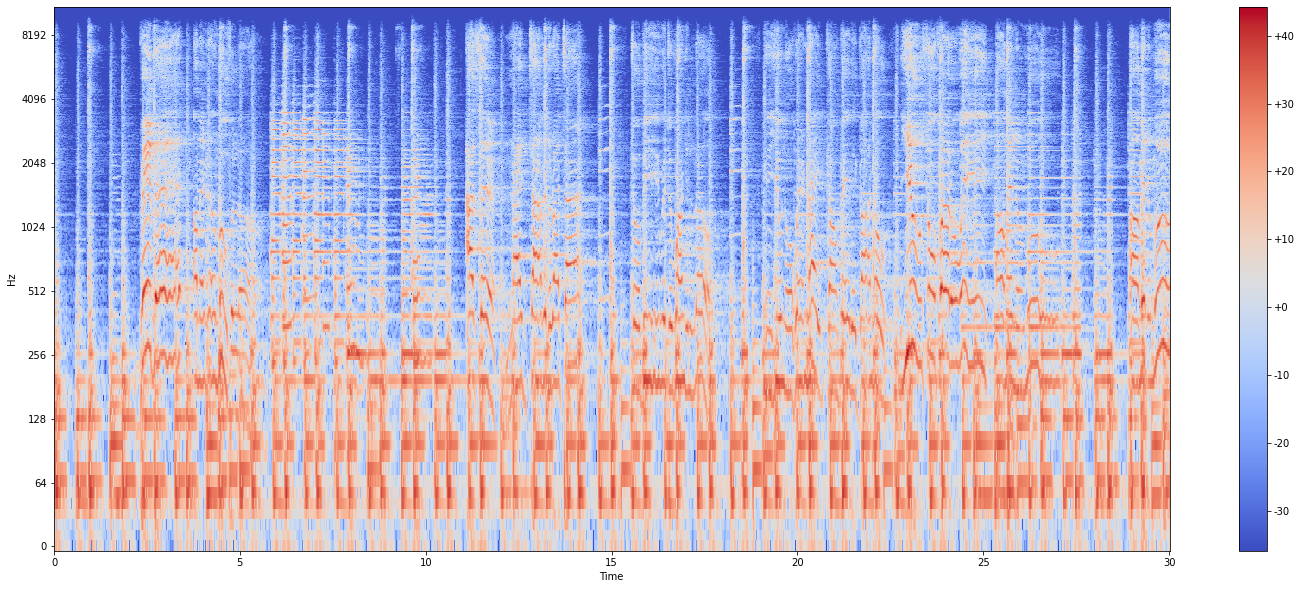

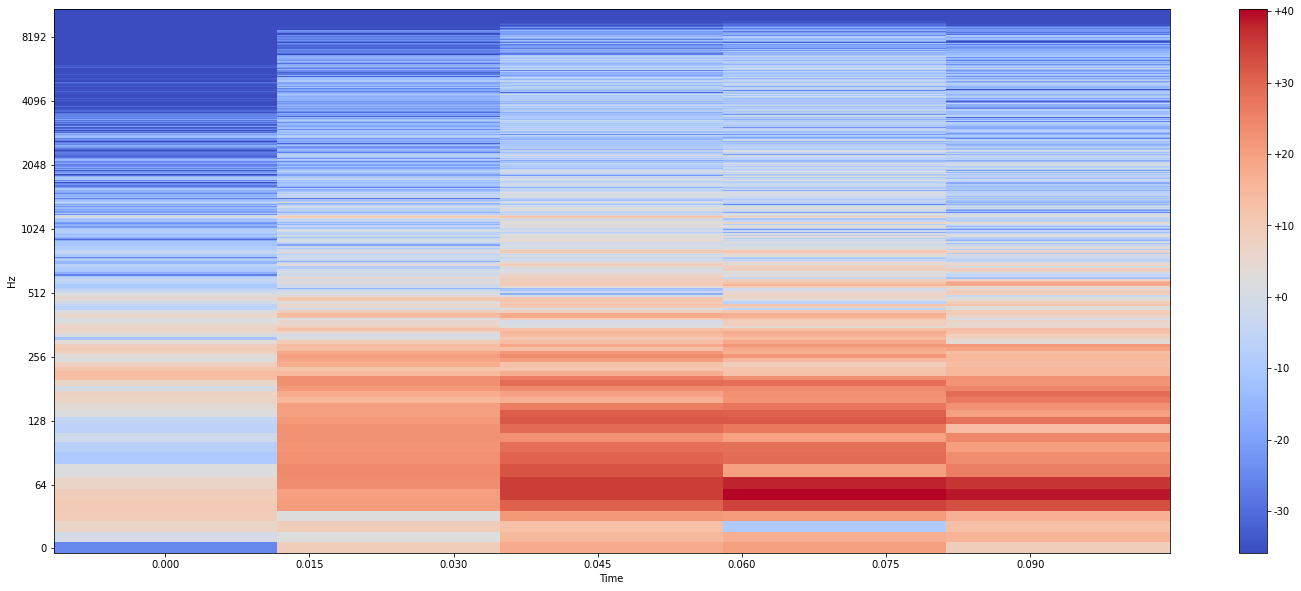

In [3]:
FRAME_SIZE = 2048
HOP_SIZE = 512
debussy_file = "blues.00001.wav"
debussy, sr = librosa.load(debussy_file)

def plot_spectrogram(Y, sr, hop_length, y_axis="linear"):
    plt.figure(figsize=(25, 10))
    librosa.display.specshow(Y, 
                             sr=sr, 
                             hop_length=hop_length, 
                             x_axis="time", 
                             y_axis=y_axis)
    plt.colorbar(format="%+2.f")
    

S_debussy = librosa.stft(debussy, n_fft=FRAME_SIZE, hop_length=HOP_SIZE)


Y_debussy = librosa.power_to_db(np.abs(S_debussy) ** 2)
print(np.shape(Y_debussy))

Y_debussy_block=Y_debussy[:,0:5]
print(np.shape(Y_debussy_block))
plot_spectrogram(Y_debussy, sr, HOP_SIZE, y_axis="log")
plot_spectrogram(Y_debussy_block, sr, HOP_SIZE, y_axis="log")


In [4]:
def getNeighbors(trainingSet, instance, k):
    distances = []
    for x in range(len(trainingSet)):
        dist = distance(trainingSet[x], instance, k) + distance(instance, trainingSet[x], k)
        distances.append((trainingSet[x][2], dist))

    distances.sort(key=operator.itemgetter(1))
    neighbors = []
    for x in range(k):
        neighbors.append(distances[x][0])
    
    return neighbors

In [5]:
# identify the class of the instance
def nearestClass(neighbors):
    classVote = {}

    for x in range(len(neighbors)):
        response = neighbors[x]
        if response in classVote:
            classVote[response] += 1
        else:
            classVote[response] = 1

    sorter = sorted(classVote.items(), key = operator.itemgetter(1), reverse=True)

    return sorter[0][0]
# function to evaluate the model
def getAccuracy(testSet, prediction):
    correct = 0
    for x in range(len(testSet)):
        if testSet[x][-1] == predictions[x]:
            correct += 1
    
    return (1.0 * correct) / len(testSet)

In [11]:
# directory that holds the wav files
directory = "GTZAN_dataset/Data/genres_original/"

# binary file where we will collect all the features extracted using mfcc (Mel Frequency Cepstral Coefficients)
f = open("my1.dat", 'wb')

i = 0

for folder in os.listdir(directory):
    i += 1
    if i == 11:
        break
    for file in os.listdir(directory+folder):        
        try:
            (rate, sig) = wav.read(directory+folder+"/"+file)
            mfcc_feat = mfcc(sig, rate, winlen=0.020, appendEnergy=False)
            covariance = np.cov(np.matrix.transpose(mfcc_feat))
            mean_matrix = mfcc_feat.mean(0)
            feature = (mean_matrix, covariance, i)
            pickle.dump(feature, f)
        except Exception as e:
            print('Got an exception: ', e, ' in folder: ', folder, ' filename: ', file)        

f.close()

In [13]:
dataset = []

def loadDataset(filename, split, trSet, teSet):
    with open('my1.dat', 'rb') as f:
        while True:
            try:
                dataset.append(pickle.load(f))
            except EOFError:
                f.close()
                break
    for x in range(len(dataset)):
        if random.random() < split:
            trSet.append(dataset[x])
        else:
            teSet.append(dataset[x])
trainingSet = []
testSet = []
loadDataset('my1.dat', 0.66, trainingSet, testSet)
print(np.shape(trainingSet))
print(testSet[100][2])

(653, 3)
4


In [13]:
def distance(instance1 , instance2 , k ):
    distance =0 
    mm1 = instance1[0] 
    cm1 = instance1[1]
    mm2 = instance2[0]
    cm2 = instance2[1]
    distance = np.trace(np.dot(np.linalg.inv(cm2), cm1)) 
    distance+=(np.dot(np.dot((mm2-mm1).transpose() , np.linalg.inv(cm2)) , mm2-mm1 )) 
    distance+= np.log(np.linalg.det(cm2)) - np.log(np.linalg.det(cm1))
    distance-= k
    return distance

In [14]:
leng = len(testSet)
predictions = []
for x in range(leng):
    predictions.append(nearestClass(getNeighbors(trainingSet, testSet[x], 5)))

accuracy1 = getAccuracy(testSet, predictions)
print(accuracy1)


0.7060702875399361


CONFUSION MATRIX
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
[3, 1, 1, 1, 

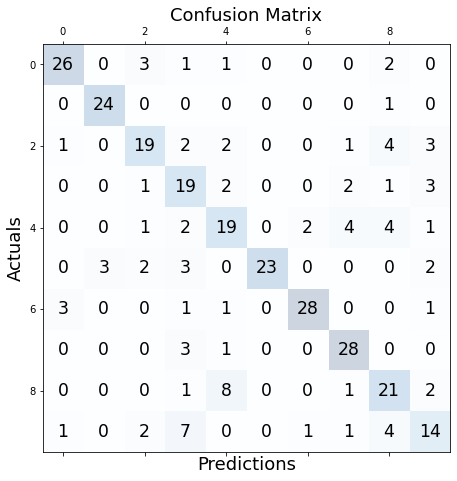

In [15]:
from sklearn.metrics import classification_report
print('CONFUSION MATRIX')
test= []
ar=['blues',  'classical', 'country',  'disco',  'hiphop', 'jazz',  'metal',  'pop',  'reggae',  'rock']
for x in range(len(predictions)):
        test.append(testSet[x][-1])
print(test)
print(predictions)
print(classification_report(test, predictions))
conf_matrix = confusion_matrix(y_true=test, y_pred=predictions)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.2)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()


22050
[-0.02876757 -0.03256934 -0.02743246 ... -0.04346118 -0.03908836
  0.        ]
7.250022675736961
(723, 13)


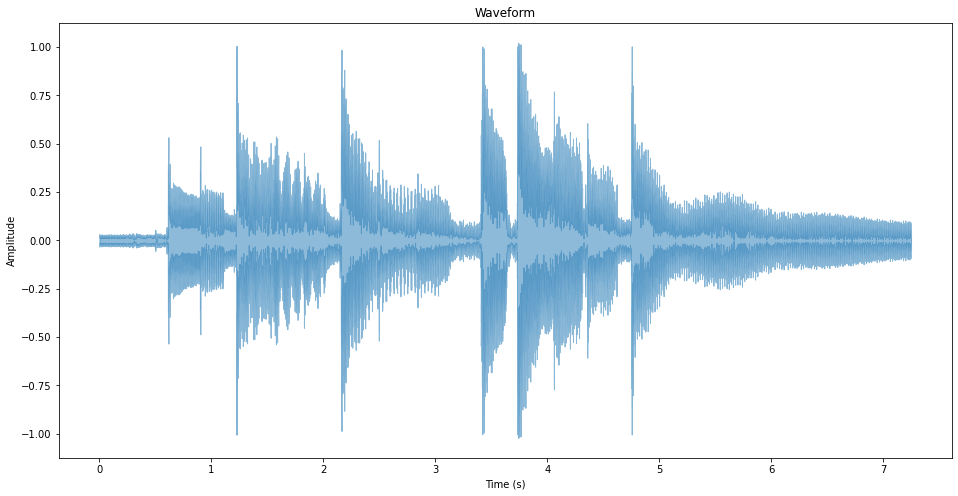

In [16]:
test_file = "deep-learning-music-genre-classification_Test_test4.wav"
sig,rate = librosa.load(test_file)
print(rate)
print(sig)
print(np.size(sig)/rate)
FIG_SIZE = (16,8)
# WAVEFORM
plt.figure(figsize=FIG_SIZE)
librosa.display.waveshow(sig,alpha=0.5)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Waveform")

mfcc_feat = mfcc(sig, rate, winlen=0.020, appendEnergy=False)
print(np.shape(mfcc_feat))
covariance = np.cov(np.matrix.transpose(mfcc_feat))
mean_matrix = mfcc_feat.mean(0)
feature = (mean_matrix, covariance,0)

In [11]:
from collections import defaultdict
results = defaultdict(int)

directory = "GTZAN_dataset/Data/genres_original/"

i = 1
for folder in os.listdir(directory):
    results[i] = folder
    i += 1
print(results)    
pred = nearestClass(getNeighbors(dataset, feature, 5))
print(results[pred])

defaultdict(<class 'int'>, {1: 'blues', 2: 'classical', 3: 'country', 4: 'disco', 5: 'hiphop', 6: 'jazz', 7: 'metal', 8: 'pop', 9: 'reggae', 10: 'rock'})
classical
